In [2]:
import pandas as pd

# Reload the datasets
athletes_data_path = 'clean_athletes_data.csv'
program_data_path = 'clean_program_data.csv'
medal_counts_path = 'medal_counts.csv'

# Read the CSV files
athletes_data = pd.read_csv(athletes_data_path)
program_data = pd.read_csv(program_data_path)
medal_counts = pd.read_csv(medal_counts_path)

# Display a summary of the data to ensure successful loading
datasets_summary = {
    "Athletes Data Head": athletes_data.head(),
    "Program Data Head": program_data.head(),
    "Medal Counts Head": medal_counts.head(),
    "Athletes Data Columns": athletes_data.columns.tolist(),
    "Program Data Columns": program_data.columns.tolist(),
    "Medal Counts Columns": medal_counts.columns.tolist()
}

datasets_summary


{'Athletes Data Head':    Column1                   Name Sex  NOC  Year         City       Sport  \
 0        1              A Dijiang   M  CHN  1992    Barcelona  Basketball   
 1        2               A Lamusi   M  CHN  2012       London        Judo   
 2        3            Gunnar Aaby   M  DEN  1920    Antwerpen    Football   
 3        4  Cornelia (-strannood)   F  NED  1932  Los Angeles   Athletics   
 4        5  Cornelia (-strannood)   F  NED  1932  Los Angeles   Athletics   
 
                                     Event  Medal  
 0             Basketball Men's Basketball      0  
 1            Judo Men's Extra-Lightweight      0  
 2                 Football Men's Football      0  
 3            Athletics Women's 100 metres      0  
 4  Athletics Women's 4 x 100 metres Relay      0  ,
 'Program Data Head':    Unnamed: 0     Sport         Discipline Code  1920  1924  1928  1932  1936  \
 0           1  Aquatics  Artistic Swimming  SWA     0     0     0     0     0   
 1        

In [3]:
# Reload necessary files
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# File paths
athletes_data_path = 'clean_athletes_data.csv'
program_data_path = 'clean_program_data.csv'
medal_counts_path = 'medal_counts.csv'

# Reading the datasets
athletes_data = pd.read_csv(athletes_data_path)
program_data = pd.read_csv(program_data_path)
medal_counts = pd.read_csv(medal_counts_path)

# Restarting the model with improvements for handling historical medals and national advantage scores

# Calculate historical medal counts for each athlete
athletes_data["Medal_Score"] = athletes_data["Medal"].map({3: 10, 2: 6, 1: 3, 0: 0})
athletes_data["Historical_Gold"] = athletes_data.groupby("Name")["Medal"].transform(lambda x: (x == 3).sum())
athletes_data["Historical_Silver"] = athletes_data.groupby("Name")["Medal"].transform(lambda x: (x == 2).sum())
athletes_data["Historical_Bronze"] = athletes_data.groupby("Name")["Medal"].transform(lambda x: (x == 1).sum())


# Historical weighted medal score
alpha, beta, gamma = 10, 6, 3
athletes_data["Historical_Score"] = (
    alpha * athletes_data["Historical_Gold"] +
    beta * athletes_data["Historical_Silver"] +
    gamma * athletes_data["Historical_Bronze"]
)

#  Calculate national project advantage score
country_project_medals = athletes_data.groupby(["NOC", "Sport"])["Medal_Score"].sum().reset_index()
country_project_medals = country_project_medals.rename(columns={"Medal_Score": "Country_Project_Medals"})

total_project_medals = athletes_data.groupby("Sport")["Medal_Score"].sum().reset_index()
total_project_medals = total_project_medals.rename(columns={"Medal_Score": "Total_Project_Medals"})

project_advantage = pd.merge(
    country_project_medals, total_project_medals, on="Sport", how="left"
)
project_advantage["Advantage_Score"] = (
    project_advantage["Country_Project_Medals"] / project_advantage["Total_Project_Medals"]
)

# Reapplying the logic for adjusted scores considering experience and gender

# Add participation count (experience) for each athlete
# Group by athlete name and count the number of unique years they participated in
athletes_data["Participation_Count"] = athletes_data.groupby("Name")["Year"].transform("nunique")

#  Define an experience curve based on a quadratic function
# Assumed coefficients of the experience curve: P(e) = alpha * e - beta * e^2 + gamma
alpha, beta, gamma = 0.5, 0.1, 1.0

# Calculate experience-based score adjustment
athletes_data["Experience_Score"] = (
    alpha * athletes_data["Participation_Count"]
    - beta * athletes_data["Participation_Count"] ** 2
    + gamma
)

# Ensure no negative scores (if the quadratic model generates negative values)
athletes_data["Experience_Score"] = athletes_data["Experience_Score"].clip(lower=0)

# Adjust scores based on gender
gender_score_map = {"M": 1.00, "F": 1.05} 
athletes_data["Gender_Score"] = athletes_data["Sex"].map(gender_score_map)


# Merge the advantage score back into the athlete data
athletes_data = pd.merge(
    athletes_data, project_advantage[["NOC", "Sport", "Advantage_Score"]],
    on=["NOC", "Sport"], how="left"
)
athletes_data["Advantage_Score"] = athletes_data["Advantage_Score"].fillna(0)
# Normalize the factors for the model
scaler = MinMaxScaler()
athletes_data["Medal_Score_Norm"] = scaler.fit_transform(athletes_data[["Medal_Score"]])
athletes_data["Historical_Score_Norm"] = scaler.fit_transform(athletes_data[["Historical_Score"]])
athletes_data["Advantage_Score_Norm"] = scaler.fit_transform(athletes_data[["Advantage_Score"]])
athletes_data["Experience_Score_Norm"] = scaler.fit_transform(athletes_data[["Experience_Score"]])

# Recalculate the overall score
w1, w2, w3, w4 = 0.3,0.4,0.2,0.1  # Adjusted weights for the components
athletes_data["Final_Adjusted_Score"] = (
    w1 * (athletes_data["Medal_Score"] + athletes_data["Historical_Score"]) +
    w2 * athletes_data["Advantage_Score"] +
    w3 * athletes_data["Experience_Score"] + 
    w4 * athletes_data["Gender_Score"]        
)




# Aggregate scores at the country and year level
final_scores = athletes_data.groupby(["NOC", "Year"])["Final_Adjusted_Score"].sum().reset_index()
final_scores = final_scores.rename(columns={"Final_Adjusted_Score": "Total_Final_Score"})




In [4]:
final_scores.head(1000)

output_file_path = "athletes_data_output.csv"
athletes_data.to_csv(output_file_path, index=False)

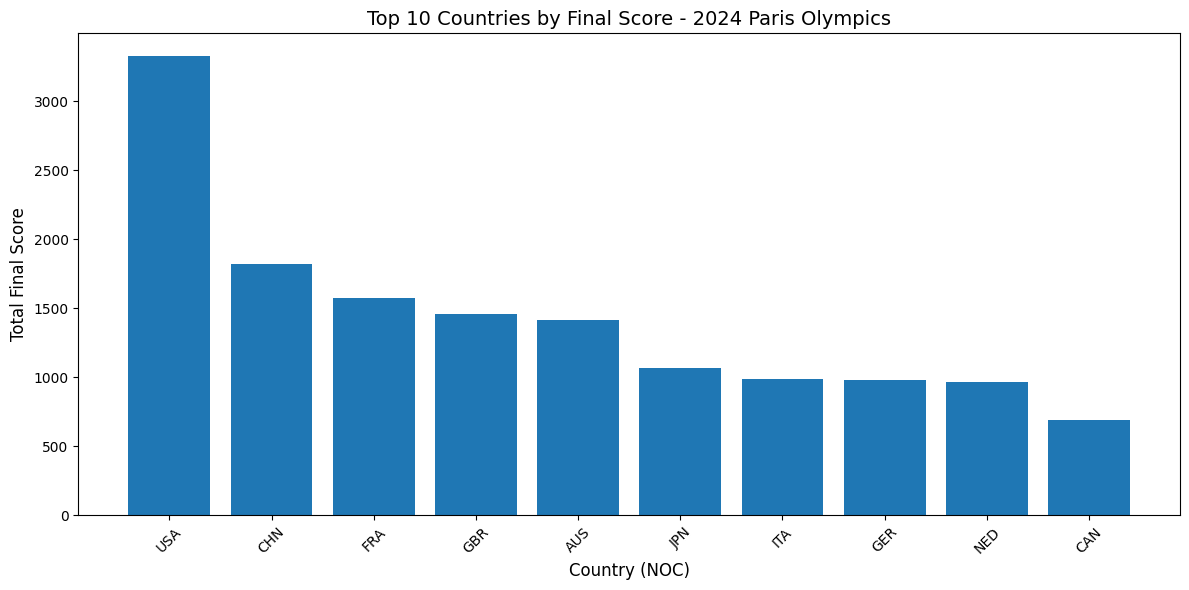

In [11]:
# Filter the data for 2024 and visualize the top 10 countries
scores_2024 = final_scores[final_scores["Year"] == 2024]
top_10_countries_2024 = scores_2024.nlargest(10, "Total_Final_Score")
output_file_path = "RatingModelTest/2024_actual.csv"
final_scores.to_csv(output_file_path, index=False)
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(top_10_countries_2024["NOC"], top_10_countries_2024["Total_Final_Score"])
plt.title("Top 10 Countries by Final Score - 2024 Paris Olympics", fontsize=14)
plt.xlabel("Country (NOC)", fontsize=12)
plt.ylabel("Total Final Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
prophet_predictions = []
# Filter for countries with scores in 2024
countries_2024 = final_scores[final_scores["Year"] == 2024]["NOC"].unique()
for country in countries_2024:
    # Extract time series data for the country
    country_data = final_scores[final_scores["NOC"] == country]
    country_data = country_data.sort_values("Year")
    prophet_data = country_data.rename(columns={"Year": "ds", "Total_Final_Score": "y"})
    prophet_data["ds"] = pd.to_datetime(prophet_data["ds"], format='%Y')
    try:
        # Fit the Prophet model
        model = Prophet()
        model.fit(prophet_data)
        # Predict for 2028
        future = model.make_future_dataframe(periods=4, freq="Y")
        forecast = model.predict(future)
        if pd.to_datetime("2027-12-31") in forecast["ds"].values:
            forecast_2028 = forecast[forecast["ds"] == pd.to_datetime("2027-12-31")]["yhat"].values[0]
        else:
            print(f"No forecast for 2028 for {country}")
            forecast_2028 = None
        # Append the prediction
        prophet_predictions.append({"NOC": country, "Year": 2028, "Predicted_Score": forecast_2028})
    except Exception as e:
        print(f"Prophet failed for {country}: {e}")
        prophet_predictions.append({"NOC": country, "Year": 2028, "Predicted_Score": None})
# Create a DataFrame for predictions
predictions_df = pd.DataFrame(prophet_predictions)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
18:37:18 - cmdstanpy - INFO - Chain [1] start processing
18:37:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:37:18 - cmdstanpy - INFO - Chain [1] start processing
18:37:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfr

Prophet failed for AIN: Dataframe has less than 2 non-NaN rows.


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:37:18 - cmdstanpy - INFO - Chain [1] start processing
18:37:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:37:18 - cmdstanpy - INFO - Chain [1] start processing
18:37:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprec

In [7]:
print(predictions_df)



     NOC  Year  Predicted_Score
0    AFG  2028         1.510827
1    AIN  2028              NaN
2    ALB  2028         5.663449
3    ALG  2028        47.569622
4    AND  2028         2.066821
..   ...   ...              ...
201  VIE  2028        14.047971
202  VIN  2028         0.623934
203  YEM  2028         1.562843
204  ZAM  2028         6.638506
205  ZIM  2028        39.878348

[206 rows x 3 columns]


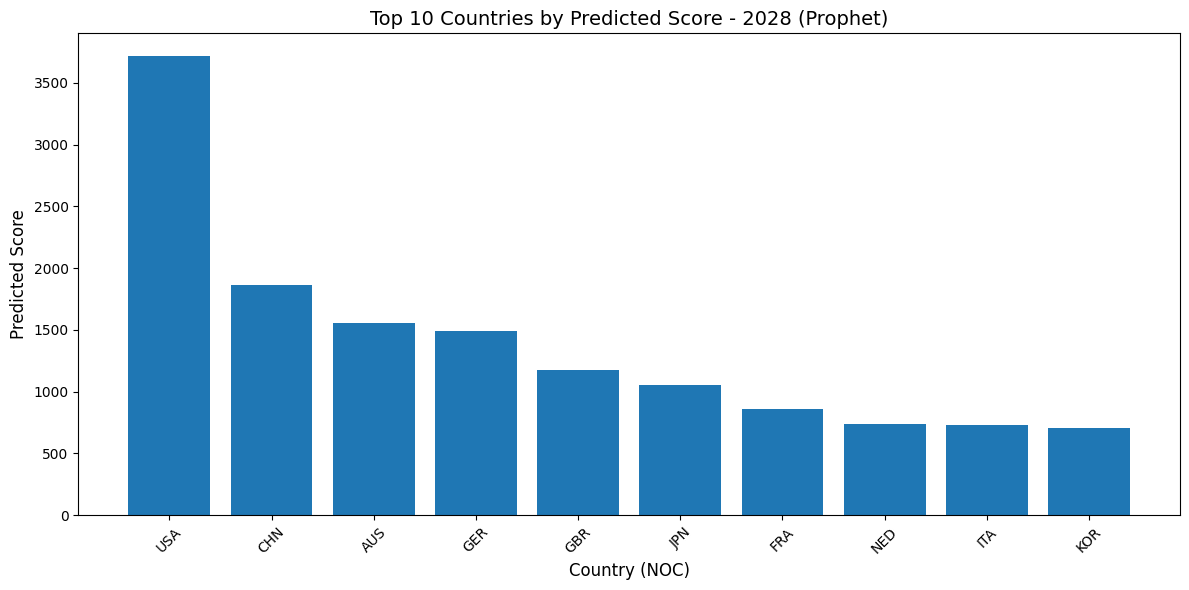

In [ ]:
# Step 5: Visualize top 10 countries by predicted score in 2028
top_10_prophet_2028 = predictions_df.nlargest(10, "Predicted_Score")
plt.figure(figsize=(12, 6))
plt.bar(top_10_prophet_2028["NOC"], top_10_prophet_2028["Predicted_Score"])
plt.title("Top 10 Countries by Predicted Score - 2028 (Prophet)", fontsize=14)
plt.xlabel("Country (NOC)", fontsize=12)
plt.ylabel("Predicted Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

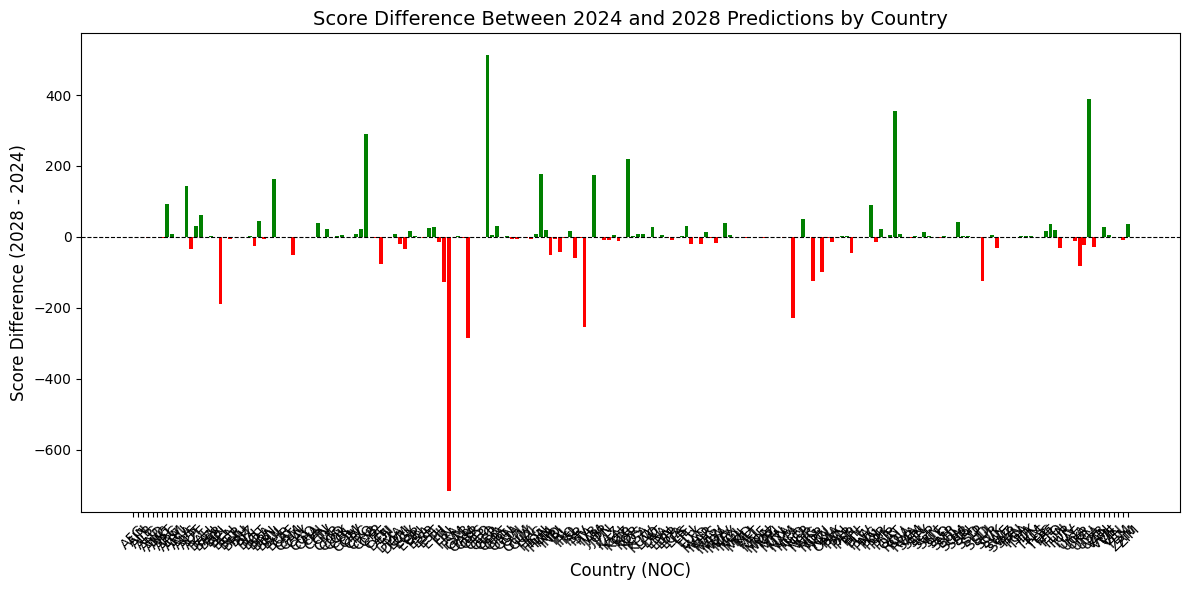

In [ ]:
# Ensure predictions and 2024 data are ready
# Join predictions for 2028 with 2024 actual scores
predictions_with_2024 = pd.merge(
    predictions_df, 
    final_scores[final_scores["Year"] == 2024][["NOC", "Total_Final_Score"]].rename(columns={"Total_Final_Score": "Score_2024"}), 
    on="NOC", 
    how="left"
)
# Calculate the difference between predicted 2028 and actual 2024 scores
predictions_with_2024["Score_Difference"] = predictions_with_2024["Predicted_Score"] - predictions_with_2024["Score_2024"]
# Plot comparison: better or worse in 2028
plt.figure(figsize=(12, 6))
plt.bar(
    predictions_with_2024["NOC"], 
    predictions_with_2024["Score_Difference"], 
    color=["green" if x > 0 else "red" for x in predictions_with_2024["Score_Difference"]]
)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Score Difference Between 2024 and 2028 Predictions by Country", fontsize=14)
plt.xlabel("Country (NOC)", fontsize=12)
plt.ylabel("Score Difference (2028 - 2024)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

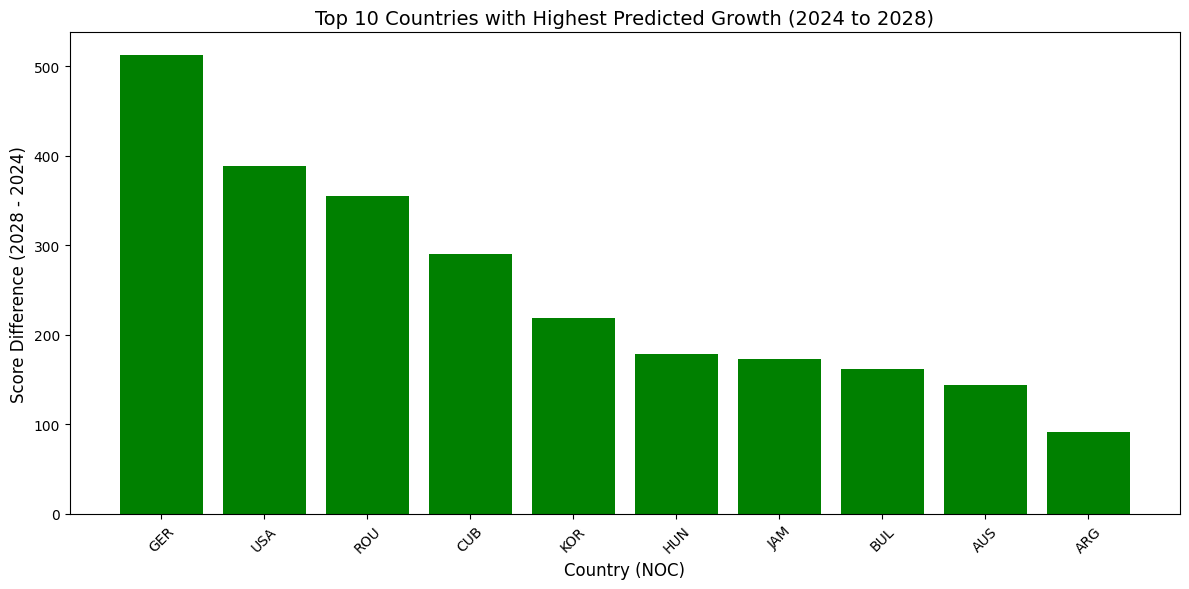

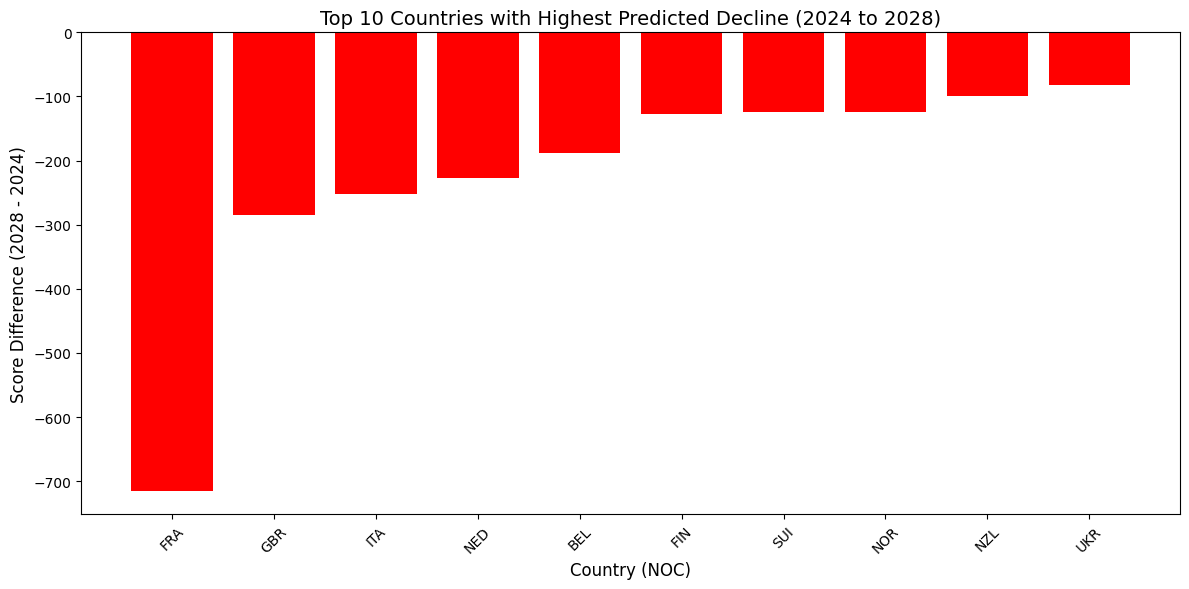

In [10]:
# Ensure the predictions_with_2024 dataset is ready
# Sort countries by score difference
top_10_growth = predictions_with_2024.nlargest(10, "Score_Difference")
top_10_decline = predictions_with_2024.nsmallest(10, "Score_Difference")

# Plot the top 10 growth countries
plt.figure(figsize=(12, 6))
plt.bar(top_10_growth["NOC"], top_10_growth["Score_Difference"], color="green")
plt.title("Top 10 Countries with Highest Predicted Growth (2024 to 2028)", fontsize=14)
plt.xlabel("Country (NOC)", fontsize=12)
plt.ylabel("Score Difference (2028 - 2024)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

# Plot the top 10 decline countries
plt.figure(figsize=(12, 6))
plt.bar(top_10_decline["NOC"], top_10_decline["Score_Difference"], color="red")
plt.title("Top 10 Countries with Highest Predicted Decline (2024 to 2028)", fontsize=14)
plt.xlabel("Country (NOC)", fontsize=12)
plt.ylabel("Score Difference (2028 - 2024)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

